In [2]:
#This is directly from the article  https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

import networkx as nx
import pandas as pd
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'iwant'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'messageReceived'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [4]:
#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated.head(10)

,identifier,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,...,consensus,propagationTime,messageOverhead,bandwidth,messageReceived,messageDuplicated,graft,prune,iwant,ihave
0,0,unl,8,6,12,4,8,2,0.25,1.0,...,3.022872,2149.216025,1262081.5,1830.489559,1681977.0,242460.0,1537.0,125.0,17.0,109756.0
1,3,unl,8,6,12,4,8,2,0.25,3.0,...,3.026471,2160.133107,1220458.0,1606.169639,1843504.0,164486.0,2137.0,0.0,1.0,4868.0
2,6,unl,16,8,20,16,8,4,0.50,1.0,...,3.027537,2008.636699,991947.5,1299.755180,1428254.0,124371.0,2138.0,0.0,0.0,792.0
3,12,unl,16,8,20,16,8,4,0.50,0.5,...,3.073917,6674.953667,388920.0,621.536311,762906.0,156136.0,1387.0,135.0,12.0,71454.0
4,13,unl,6,4,8,2,2,2,0.25,1.0,...,3.038808,3089.497825,859426.5,1362.596343,1778309.0,351875.0,1469.0,308.0,46.0,141786.0
5,18,unl,6,4,8,2,2,4,0.25,0.5,...,3.014395,2097.297225,391164.5,592.199166,870750.0,151214.0,2136.0,0.0,2.0,4869.0
6,21,unl,20,16,24,8,16,8,0.50,1.0,...,3.029904,2013.597379,1063446.0,1429.535814,1998816.0,205431.0,2134.0,0.0,0.0,9774.0
7,23,unl,16,8,20,4,8,2,0.50,1.0,...,3.021019,2353.420496,1347907.5,1784.607281,2013329.0,198723.0,1819.0,0.0,14.0,8629.0
8,27,unl,16,8,20,8,8,4,0.25,1.0,...,3.025704,1903.031597,952511.0,1281.485378,1957411.0,217007.0,2138.0,0.0,1.0,9194.0
9,29,unl,16,8,20,4,8,2,0.25,1.0,...,3.044116,1963.333217,809796.5,1166.508678,1008492.0,108908.0,1777.0,14.0,23.0,185785.0


In [5]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, consolidated)

In [6]:
#Fit model to data
gcm.fit(scm, consolidated)

Fitting causal mechanism of node bandwidth: 100%|██████████| 10/10 [00:00<00:00, 71.04it/s]     


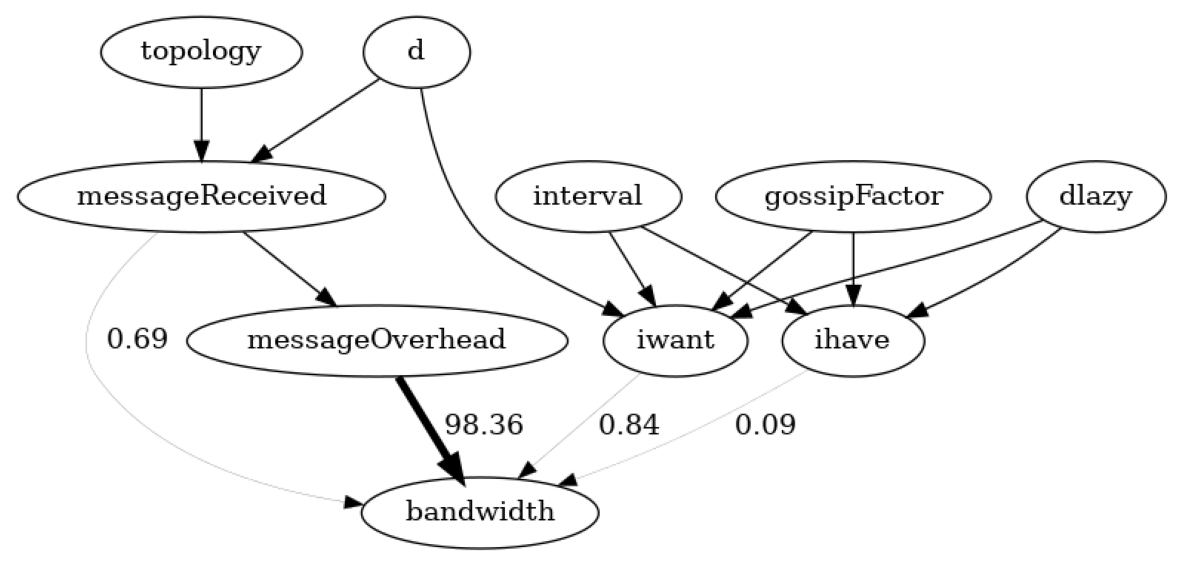

In [7]:
#Key factors influencing Bandwidth?

def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='bandwidth')


fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(causal_graph, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): -14.198840186465098%: 100%|██████████| 1/1 [00:41<00:00, 41.21s/it]


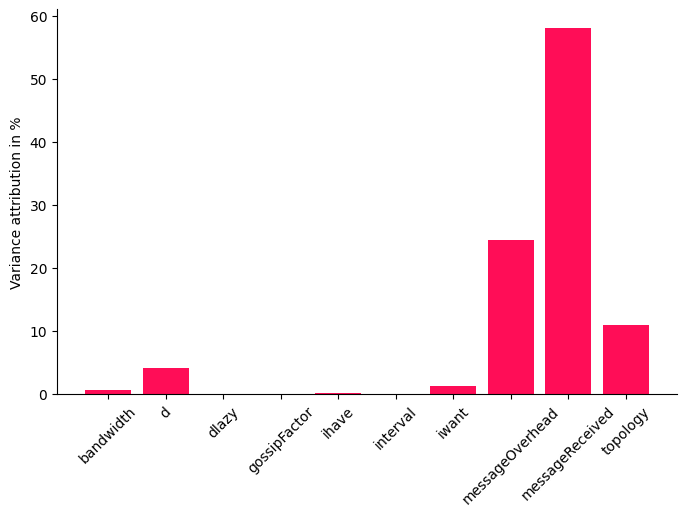

In [8]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='bandwidth', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

<AxesSubplot:>

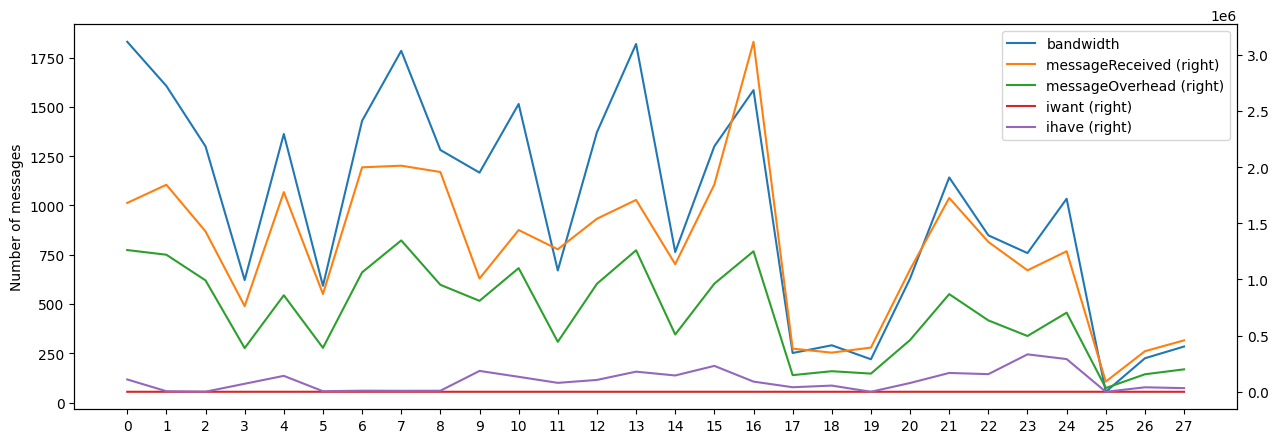

In [9]:
fig, ax = plt.subplots(figsize=(15,5)) 

ax = consolidated.plot(y='bandwidth', ylabel='Bandwidth in messages/s', rot=45, xticks=consolidated.index, ax=ax)
consolidated.plot(y='messageReceived', ax=ax, secondary_y = True, ylabel='Number of messages')

consolidated.plot(y = 'messageOverhead', ax=ax, secondary_y = True)
consolidated.plot(y = 'iwant', ax=ax, secondary_y = True)
consolidated.plot(y='ihave', ax=ax, secondary_y = True)
